# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [126]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.cluster import KMeans
import ast

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
feature_values = pd.read_excel('/home/workspace/DIAS Attributes - Values 2017.xlsx', header = 1, usecols = [1,2,3,4]).fillna(method = 'ffill')

In [6]:
feature_attributes = pd.read_excel('/home/workspace/DIAS Information Levels - Attributes 2017.xlsx', header = 1, usecols = [1,2,3,4]).fillna(method = 'ffill')

### Take a look at the data sets to see what they reveal.

In [74]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [75]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [76]:
feature_values.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [77]:
feature_attributes.head(20)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,modelled on millions of first name-age-referen...
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,Person,FINANZ_SPARER,financial typology: money saver,Gfk-Typology based on a representative househo...
6,Person,FINANZ_VORSORGER,financial typology: be prepared,Gfk-Typology based on a representative househo...
7,Person,FINANZ_ANLEGER,financial typology: investor,Gfk-Typology based on a representative househo...
8,Person,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,Gfk-Typology based on a representative househo...
9,Person,FINANZ_HAUSBAUER,financial typology: main focus is the own house,Gfk-Typology based on a representative househo...


#### From observing the feature_values data frame it appears that there are categories that have labels of 0 and -1 that are unknown values. They should be imputed somehow when cleaning the data frames up. 

## Part 1: Customer Segmentation Report

In this part of the project the data will be examined to determine the relationship between the customers and the general population of Germany by examing the demographics of the data. 

In [79]:
azdias.shape

(891221, 366)

In [80]:
customers.shape

(191652, 369)

There are some columns in the Azdias data frame that don't have a description in the 'feature_values' csv file. 

In [50]:
attributes_described = list(feature_values["Attribute"].unique())
attributes_described[1:15]

['ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_DEUINTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12']

In [51]:
len(attributes_described)

314

In [48]:
azdias_columns = list(azdias.columns)
azdias_columns[1:20]
len(azdias_columns)

366

In [57]:
undescribed_columns_azdias = [col for col in azdias_columns if col not in attributes_described]

In [58]:
undescribed_columns_azdias

['LNR',
 'AKT_DAT_KL',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSI_DATUM

In [59]:
len(undescribed_columns_azdias)

94

So, it appears there are 94 columns in the Azdias data frame that don't have a description for what they mean. For now the columns will be kept regardless of this deficiency.

In [60]:
extra_columns_customers = [col for col in customers.columns if col not in azdias.columns]

In [61]:
extra_columns_customers

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'). In order to keep the data consistent for comparison matching these 3 columns should be removed from the 'CUSTOMERS' data set. 

In [62]:
customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], axis=1)

In [84]:
cat_cols = azdias.select_dtypes(include=['object'])
cat_cols.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


It may be good to know what each of these columns mean. That help determine if they have useful information or not. Looking at the "DIAS Atrributes" csv file provides some insight.

In [85]:
feature_values[feature_values['Attribute'] == 'CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


So it looks like 'CAMEO_DEUG_2015' tells the economic class of someone. They are divided into 9 economic classes so given a categorical value of 1-9, and if it is unknown that person is given a -1. 

In [86]:
feature_values[feature_values['Attribute'] == 'CAMEO_DEU_2015']

,Attribute,Description,Value,Meaning
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
62,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1B,Wealthy Best Ager
63,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1C,Successful Songwriter
64,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1D,Old Nobility
65,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1E,City Nobility
66,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2A,Cottage Chic
67,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2B,Noble Jogger
68,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2C,Established gourmet
69,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2D,Fine Management
70,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,3A,Career & Family


The columns 'CAMEO_DEU_2015' refers to some classification of the person such as retiree, gardener, etc. 

In [88]:
feature_values[feature_values['Attribute'] == 'OST_WEST_KZ']

,Attribute,Description,Value,Meaning
2013,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown
2014,OST_WEST_KZ,flag indicating the former GDR/FRG,O,East (GDR)
2015,OST_WEST_KZ,flag indicating the former GDR/FRG,W,West (FRG)


And 'OST_WEST_KZ' is some kind of geographic indicator, also contains unknown values

Next check for the 'CAMEO_INTL_2015' category:

In [93]:
feature_values[feature_values['Attribute'] == 'CAMEO_INTL_2015']

,Attribute,Description,Value,Meaning


There is no description available for the CAMEO_INTL_2015 column.

In [94]:
feature_values[feature_values['Attribute'] == 'D19_LETZTER_KAUF_BRANCHE']

,Attribute,Description,Value,Meaning


Again, no description os available for the D19_LETZTER_KAUF_BRANCHE column either. But from translation of the words it means "Last Purchase Sector". 

In [95]:
unique_classes = []
for j in (cat_cols):
    unique_classes.append(cat_cols[j].unique())

Now it can be seen what the unique classes are for each categorical category:

In [97]:
cat_col_names = cat_cols.columns
for i in zip(cat_col_names, unique_classes):
    print(i)

('CAMEO_DEU_2015', array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object))
('CAMEO_DEUG_2015', array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object))
('CAMEO_INTL_2015', array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object))
('D19_LETZTER_KAUF_BRANCHE', array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
       'D19

Now for cleaning up the data. The column with the dates ['EINGEFUEGT_AM'], would be a good place to start.
So, to simply the column with the dates "azdias['EINGEFUEGT_AM']", just take the year and the month and place them in new columns, then drop the original!

In [64]:
cat_cols['year'] = pd.DatetimeIndex(cat_cols['EINGEFUEGT_AM']).year

In [99]:
cat_cols.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W,1992.0
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W,1992.0
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W,1997.0
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W,1992.0


Repeat the above steps for the azdias and customers data frames. 

In [65]:
customers['year'] = pd.DatetimeIndex(customers['EINGEFUEGT_AM']).year

In [66]:
customers = customers.drop(['EINGEFUEGT_AM'], axis=1)
customers = pd.DataFrame(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4,1992.0
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4,NaN
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4,1992.0
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4,1992.0
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3,1992.0


In [67]:
azdias['year'] = pd.DatetimeIndex(azdias['EINGEFUEGT_AM']).year

In [68]:
azdias = azdias.drop(['EINGEFUEGT_AM'], axis=1)

When the data frames were first uploaded there were some warning messages "Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False." Therefore these columns and their missing data should be dealt with. 

In [118]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [106]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [108]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object)

There are values of 'X' and 'XX' given in these columns and they don't confer with the other values. They will be replaced with NaN's 

In [69]:
def convert_X(df):
    """
    Replaces values of 'X' and 'XX' with NaN and converts all values in the column to a float

    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.NaN, "XX": np.NaN})
    df[cols] = df[cols].astype(float)
    
    return df

In [73]:
convert_X(customers)

In [71]:
convert_X(azdias)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,1992.0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,1992.0
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,1997.0
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,1992.0
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,1992.0
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2,1992.0
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1,1992.0
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3,1992.0
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3,1992.0


Next, double check to make sure it worked. 

In [128]:
azdias['CAMEO_DEUG_2015'].unique()

array([ nan,   8.,   4.,   2.,   6.,   1.,   9.,   5.,   7.,   3.])

In [129]:
azdias['CAMEO_INTL_2015'].unique()

array([ nan,  51.,  24.,  12.,  43.,  54.,  22.,  14.,  13.,  15.,  33.,
        41.,  34.,  55.,  25.,  23.,  31.,  52.,  35.,  45.,  44.,  32.])

In [130]:
customers['CAMEO_DEUG_2015'].unique()

array([  1.,  nan,   5.,   4.,   7.,   3.,   9.,   2.,   6.,   8.])

In [131]:
customers['CAMEO_INTL_2015'].unique()

array([ 13.,  nan,  34.,  24.,  41.,  23.,  15.,  55.,  14.,  22.,  43.,
        51.,  33.,  25.,  44.,  54.,  32.,  12.,  35.,  31.,  45.,  52.])

This all checks out fine. 

Next, it looks like the dataframes have a lot of unknown values, represented by 0, -1, or nan. 

In [86]:
unknown_df = feature_values[feature_values['Meaning']=='unknown']
unknown_df

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown


So, it appears there are 232 columns that have unkown values. These missing values should be replaced as best as possible. 

The next step is to replace 'mixed' features. These are columns that have mixed data types. 

In [121]:
def get_unknown_values(column_name):
    unknown_val = unknown_df[unknown_df["Attribute"]==column_name].Value
    unknown = unknown_val.astype(str).str.cat(sep=",")
    unknown = [int(x) for x in unknown.split(",")]
    return unknown

In [130]:
def replace_unknown_with_nan(unknown):
    """Replaces unkown values with np.nan values"""
    if val in unknown:
        return np.nan
    else:
        return val
        

In [137]:
def convert_nan(df):
    columns = df.columns
    for col in columns:
        unknown_val = unknown_df[unknown_df["Attribute"]== col].Value
        #unknown = unknown_val.astype(str).str.cat(sep=",")
        #unknown = [int(x) for x in unknown.split(",")]
    
    #return unknown_val

In [138]:
convert_nan(customers)

In [131]:
def replace_unknowns(df, unknown_df, verbose=False):
    """
    Replaces unkown values to 'np.nan' in all the columns provided in unknown_attributes_values list.
    """
    for description in unknown_df.Attribute:
        unknown = get_unknown_values(description)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unknown, description))
        if description in df.columns:
            df[description] = df[description].apply(replace_unknown_with_nan, args=(unknown))
    return df

In [132]:
replace_unknowns(customers, unknown_df, verbose = True)

Replacing [-1] to NaN in Attribute AGER_TYP


TypeError: replace_unknown_with_nan() takes 1 positional argument but 2 were given

In [11]:
def percent_missing(df):
    percent_missing = df.isnull().sum()*100/len(df)
    null_columns = percent_missing.sort_values(ascending = False)
    return null_columns

See how much data is missing for the categorical columns of the 'azdias' and 'customer' data frames!

In [9]:
percent_missing(azdias)

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
KBA05_MOD2                     14.959701
KBA05_SEG1                     14.959701
KBA05_MOD1                     14.959701
KBA05_MAXVORB                  14.959701
KBA05_MAXSEG    

It is apparent that there is a significant amount of data missing, especially in the Azdias data frame. The D19_LETZTER_KAUF_BRANCHE column has 28.8% missing but those missing values can just be replaced later. Looking at the categorical columns such as CAMEO_INTL_2015 and CAMEO_DEUG_2015 they have about 11.1% of the their data missing. Dropping these rows might be a good place to start because perhaps those are the same rows that are also missing data for the other columns. Note that dropping one of these two columns is the samething as dropping them both because if the row is missing data in one column it is missing in the other. 

In [18]:
cat_cols = cat_cols.dropna(subset=['CAMEO_INTL_2015']) 

In [10]:
azdias = azdias.dropna(subset=['CAMEO_INTL_2015']) 

In [23]:
customers = customers.dropna(subset=['CAMEO_INTL_2015']) 

Check how that affected how much data is missing now!

In [23]:
percent_missing(cat_cols)

D19_LETZTER_KAUF_BRANCHE    22.329162
year                         0.000000
OST_WEST_KZ                  0.000000
EINGEFUEGT_AM                0.000000
CAMEO_INTL_2015              0.000000
CAMEO_DEUG_2015              0.000000
CAMEO_DEU_2015               0.000000
dtype: float64

In [24]:
percent_missing(customers)

ALTER_KIND4                  99.834306
ALTER_KIND3                  99.121254
ALTER_KIND2                  96.494930
ALTER_KIND1                  91.910723
KK_KUNDENTYP                 45.050416
EXTSEL992                    26.511783
HH_DELTA_FLAG                 4.906390
W_KEIT_KIND_HH                4.906390
KBA05_KRSZUL                  4.093497
KBA05_KW1                     4.093497
KBA05_KW2                     4.093497
KBA05_KW3                     4.093497
KBA05_ZUL4                    4.093497
KBA05_MAXAH                   4.093497
KBA05_KRSOBER                 4.093497
KBA05_MAXBJ                   4.093497
KBA05_MAXHERST                4.093497
KBA05_MAXSEG                  4.093497
KBA05_KRSVAN                  4.093497
KBA05_KRSAQUOT                4.093497
KBA05_KRSKLEIN                4.093497
KBA05_KRSHERST2               4.093497
KBA05_KRSHERST1               4.093497
KBA05_MOD1                    4.093497
KBA05_HERST5                  4.093497
KBA05_HERST4             

Looking at the categorical columns dropping 'CAMEO_INTL_2015' resulted in there being less missing data. 

In [40]:
azdias_missing = percent_missing(azdias)[0:50]

ALTER_KIND4                    99.851939
ALTER_KIND3                    99.240384
ALTER_KIND2                    96.372952
ALTER_KIND1                    90.051651
EXTSEL992                      70.842621
KK_KUNDENTYP                   62.450362
ALTERSKATEGORIE_FEIN           22.993479
D19_VERSI_ONLINE_QUOTE_12      22.329162
D19_BANKEN_ONLINE_QUOTE_12     22.329162
D19_SOZIALES                   22.329162
D19_GESAMT_ONLINE_QUOTE_12     22.329162
D19_VERSAND_ONLINE_QUOTE_12    22.329162
D19_KONSUMTYP                  22.329162
D19_LETZTER_KAUF_BRANCHE       22.329162
D19_LOTTO                      22.329162
D19_TELKO_ONLINE_QUOTE_12      22.329162
KBA05_MAXVORB                   4.818099
KBA05_MOD8                      4.818099
KBA05_MOD4                      4.818099
KBA05_MOD3                      4.818099
KBA05_MOD2                      4.818099
KBA05_MOD1                      4.818099
KBA05_KW2                       4.818099
KBA05_MAXSEG                    4.818099
KBA05_MAXHERST  

Before continuing any further the 'year' column will be created from the 'EINGEFUEGT_AM' column which will be dropped. 

Next, have a look at what the columns "ALTER_KIND" show. They are missing most of the data and don't have a description in the 'atrributes' file. But they have something do with the age of the first, second, third, and fourth oldest child. 

In [13]:
azdias["ALTER_KIND1"].unique()

array([ nan,  17.,  18.,  13.,  16.,  11.,   6.,   8.,   9.,  15.,  10.,
        14.,   7.,  12.,   4.,   3.,   5.,   2.])

In [14]:
azdias["ALTER_KIND2"].unique()

array([ nan,   8.,  12.,  10.,   7.,  16.,  15.,  14.,  17.,   5.,   9.,
        18.,  11.,  13.,   6.,   4.,   3.,   2.])

In [15]:
azdias["ALTER_KIND3"].unique()

array([ nan,  10.,  18.,  17.,  16.,   8.,  15.,  12.,  13.,  14.,  11.,
         9.,   7.,   5.,   6.,   4.])

In [16]:
azdias["ALTER_KIND4"].unique()

array([ nan,  10.,   9.,  16.,  14.,  13.,  11.,  18.,  17.,  15.,   8.,
        12.,   7.])

Next, the unique values for some of the other columns with a large percentage of missing data will be inspected such as 'KK_KUNDENTYP', 'EXTSEL992', 'ALTERSKATEGORIE_FEIN','D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12'. Note that there is not a description given for what they represent in the atrributes file. 

In [29]:
azdias['KK_KUNDENTYP'].unique()

array([ nan,   1.,   3.,   6.,   4.,   2.,   5.])

In [30]:
azdias['EXTSEL992'].unique()

array([ nan,  14.,  31.,  20.,  56.,  53.,  27.,  54.,   6.,  25.,  48.,
        55.,  36.,  34.,  35.,  18.,  38.,  32.,  41.,  29.,  43.,  22.,
        19.,  24.,  23.,   8.,  21.,  37.,   7.,   3.,  39.,  12.,  15.,
        17.,   4.,   9.,  44.,  50.,  13.,  33.,  42.,  49.,   1.,  30.,
        10.,  45.,  26.,  16.,  28.,  47.,   2.,  46.,  11.,  40.,  51.,
        52.,   5.])

In [48]:
azdias['ALTERSKATEGORIE_FEIN'].unique() 

array([ 21.,  17.,  13.,  14.,  10.,  nan,  16.,  20.,  11.,  19.,  15.,
        18.,   9.,  22.,  12.,   0.,   8.,   7.,  23.,   4.,  24.,   6.,
         3.,   2.,   5.,  25.,   1.])

In [52]:
azdias['D19_BANKEN_ONLINE_QUOTE_12'].unique() 

array([ nan,   0.,  10.,   8.,   9.,   7.,   5.,   6.,   3.,   4.,   2.,
         1.])

In [22]:
azdias[['D19_BANKEN_ONLINE_QUOTE_12']].head(15)

,D19_BANKEN_ONLINE_QUOTE_12
0,NaN
1,NaN
2,0.0
3,0.0
4,10.0
5,0.0
6,0.0
7,0.0
8,NaN
9,0.0


The missing data in the 'ALTER_KIND' categories will be addressed now. Most of it is missing or has a value of zero. Missing values will just be replaced with a zero and non-zero values will just be given a one, so essentially this category data will be converted to binary. 

In [14]:
ALTER_KIND_LIST = ["ALTER_KIND1","ALTER_KIND2","ALTER_KIND3","ALTER_KIND4"]

In [15]:
def ALTER_KIND_clean(df):
    for i in ALTER_KIND_LIST:
        df[i] = df[i].fillna(0)
        df[i].values[df[i].values > 0] = 1

In [16]:
ALTER_KIND_clean(customers)

In [19]:
ALTER_KIND_clean(azdias)

A quick check to make sure this last step worked okay. 

In [17]:
customers[['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3']].head(50)

,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,0.0,0.0,0.0
9,0.0,0.0,0.0


And the answer is yes, the function successfuly converted the categories to binary.

As for the 'KK_KUNDENTYP' and 'EXTSEL992' columns, have most of their values missing, perhaps the missing values can be filled in by grouping them based on what values they have when they have the same working class (CAMEO_DEUG_2015) and customer class (CAMEO_DEU_2015) using a lambda function:

In [33]:
def fill_na_numerical(df, columns):
    for column in columns:
        df[column] = df.groupby(['CAMEO_DEUG_2015','CAMEO_DEU_2015'])[column].apply(lambda x: x.fillna(x.median()))

The next step is the apply the 'fill_na_numerical' function to all of the numerical columns in the 'azdias' and 'customers' frames. 

In [19]:
numerical_columns = azdias.select_dtypes(exclude=['object']).columns

In [29]:
numerical_columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB', 'year'],
      dtype='object', length=361)

In [34]:
fill_na_numerical(customers, numerical_columns)

In [38]:
percent_missing(customers)

D19_LETZTER_KAUF_BRANCHE    0.747748
year                        0.000000
KBA05_ANTG2                 0.000000
HH_EINKOMMEN_SCORE          0.000000
INNENSTADT                  0.000000
KBA05_ALTER1                0.000000
KBA05_ALTER2                0.000000
KBA05_ALTER3                0.000000
KBA05_ALTER4                0.000000
KBA05_ANHANG                0.000000
KBA05_ANTG1                 0.000000
KBA05_ANTG3                 0.000000
D19_VERSI_ONLINE_DATUM      0.000000
KBA05_ANTG4                 0.000000
KBA05_AUTOQUOT              0.000000
KBA05_BAUMAX                0.000000
KBA05_CCM1                  0.000000
KBA05_CCM2                  0.000000
KBA05_CCM3                  0.000000
KBA05_CCM4                  0.000000
KBA05_DIESEL                0.000000
KBA05_FRAU                  0.000000
HH_DELTA_FLAG               0.000000
HEALTH_TYP                  0.000000
GREEN_AVANTGARDE            0.000000
GFK_URLAUBERTYP             0.000000
D19_VERSICHERUNGEN          0.000000
D

In [33]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,9626,2,1.0,10.0,0.0,0.0,0.0,0.0,10.0,1.0,...,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4,1992.0
2,143872,-1,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,...,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4,1992.0
3,143873,1,1.0,8.0,0.0,0.0,0.0,0.0,8.0,0.0,...,6.0,4.0,2.0,4.0,9.0,7.0,1,1,4,1992.0
4,143874,-1,1.0,20.0,0.0,0.0,0.0,0.0,14.0,7.0,...,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3,1992.0
5,143888,1,1.0,11.0,0.0,0.0,0.0,0.0,10.0,1.0,...,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3,1992.0


The iterative function was successful. There is only one column that needs to be handled more, the 'D19_LETZTER_KAUF_BRANCHE' one. Now that it is clear it will work on a small data set, it will be done on a large one. 

In [23]:
fill_na_numerical(azdias, numerical_columns)

In [40]:
percent_missing(azdias)

D19_LETZTER_KAUF_BRANCHE    22.329162
year                         0.000000
KBA05_ANTG2                  0.000000
HH_EINKOMMEN_SCORE           0.000000
INNENSTADT                   0.000000
KBA05_ALTER1                 0.000000
KBA05_ALTER2                 0.000000
KBA05_ALTER3                 0.000000
KBA05_ALTER4                 0.000000
KBA05_ANHANG                 0.000000
KBA05_ANTG1                  0.000000
KBA05_ANTG3                  0.000000
D19_VERSI_ONLINE_DATUM       0.000000
KBA05_ANTG4                  0.000000
KBA05_AUTOQUOT               0.000000
KBA05_BAUMAX                 0.000000
KBA05_CCM1                   0.000000
KBA05_CCM2                   0.000000
KBA05_CCM3                   0.000000
KBA05_CCM4                   0.000000
KBA05_DIESEL                 0.000000
KBA05_FRAU                   0.000000
HH_DELTA_FLAG                0.000000
HEALTH_TYP                   0.000000
GREEN_AVANTGARDE             0.000000
GFK_URLAUBERTYP              0.000000
D19_VERSICHE

So, no no more missing data other than the 'D19_LETZTER_KAUF_BRANCHE' column.

Do a quick check on a numerical column such as 'KK_KUNDENTYP' to be sure that it successfuly converterted all missing data to an actual number before applying this function on all other numerical columns with missing data.

In [42]:
customers['KK_KUNDENTYP'].head(20)

0     3.0
2     3.0
3     3.0
4     2.0
5     3.0
6     5.0
7     5.0
8     4.0
9     4.0
11    1.0
12    3.0
13    1.0
14    3.0
15    5.0
16    1.0
17    4.0
18    3.0
19    2.0
20    1.0
21    3.0
Name: KK_KUNDENTYP, dtype: float64

So, all missing values here are filled in to. The Data Frame is nearly cleaned. It remains to fill in 'D19_LETZTER_KAUF_BRANCHE' and a little bit of ALTER_KIND4.

In [43]:
azdias["D19_LETZTER_KAUF_BRANCHE"].unique()

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
       'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
       'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
       'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
       'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object)

In [80]:
type(azdias["D19_LETZTER_KAUF_BRANCHE"].value_counts())

pandas.core.series.Series

In [44]:
azdias["D19_LETZTER_KAUF_BRANCHE"].value_counts()

D19_UNBEKANNT             189432
D19_VERSICHERUNGEN         56031
D19_SONSTIGE               43451
D19_VOLLSORTIMENT          33751
D19_SCHUHE                 31586
D19_BUCH_CD                27958
D19_VERSAND_REST           25274
D19_DROGERIEARTIKEL        23365
D19_BANKEN_DIREKT          22582
D19_BEKLEIDUNG_REST        21122
D19_HAUS_DEKO              20260
D19_TELKO_MOBILE           14002
D19_ENERGIE                11739
D19_TELKO_REST             11160
D19_BANKEN_GROSS           10242
D19_BEKLEIDUNG_GEH          9976
D19_KINDERARTIKEL           7081
D19_FREIZEIT                7049
D19_TECHNIK                 6807
D19_LEBENSMITTEL            6276
D19_BANKEN_REST             5086
D19_RATGEBER                4786
D19_NAHRUNGSERGAENZUNG      3968
D19_DIGIT_SERV              3474
D19_REISEN                  3032
D19_TIERARTIKEL             2502
D19_SAMMELARTIKEL           2369
D19_HANDWERK                2161
D19_WEIN_FEINKOST           2106
D19_GARTEN                  1594
D19_BANKEN

Making a bar plot:
https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.bar.html

Text(0,0.5,'Clientele Number for Azdias Data Set')

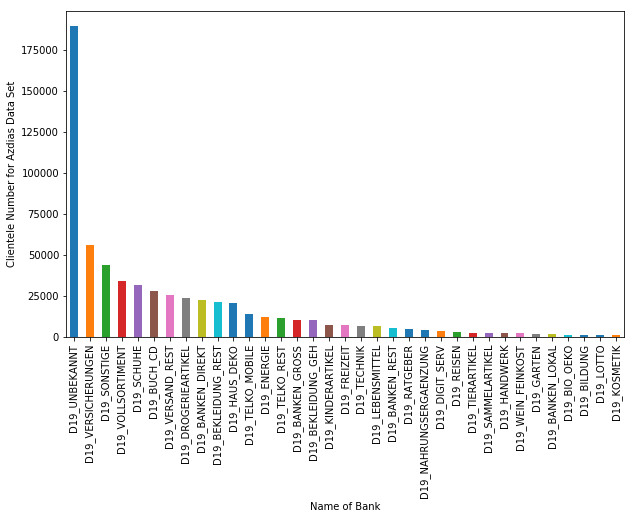

In [45]:

plt.figure(figsize=(10, 6))
azdias["D19_LETZTER_KAUF_BRANCHE"].value_counts().plot.bar()
# naming the x axis
plt.xlabel('Name of Bank')
# naming the y axis
plt.ylabel('Clientele Number for Azdias Data Set')

So, given that 28% of the data here is missing, it may not be wise to just make a new bank name value for them because then that would dominate the clientele number and be a false data point. Luckily there is a built in .fillna(method='ffill', inplace=True) that works magic by replacing the nan value with the next one after it, so it shuffles them randomly, this seems like a very good approach. 


In [24]:
azdias["D19_LETZTER_KAUF_BRANCHE"].fillna(method='ffill', inplace=True)

In [25]:
azdias["D19_LETZTER_KAUF_BRANCHE"].isnull().sum()

1

There is still one null data point, use the backfill method to fill it out!

In [26]:
azdias["D19_LETZTER_KAUF_BRANCHE"].fillna(method='bfill', inplace=True)

In [27]:
azdias["D19_LETZTER_KAUF_BRANCHE"].isnull().sum()

0

So, there is no more missing data. However, before proceeding the 'years' column will be looked at one more time. Repeat this crucial step for the 'customers' frame!  

In [26]:
customers["D19_LETZTER_KAUF_BRANCHE"].fillna(method='ffill', inplace=True)

In [27]:
customers["D19_LETZTER_KAUF_BRANCHE"].isnull().sum()

0

In [50]:
azdias['year'].unique()

array([1992, 1997, 2005, 2009, 1995, 1996, 2002, 2000, 2008, 1994, 1993,
       2003, 2007, 2004, 1999, 2010, 2001, 1998, 2006, 2014, 2013, 2012,
       2011, 2015, 1991])

Every year between 1992 and 2015 is included. A bar plot could be useful to see the distribution:

Text(0,0.5,'frequency')

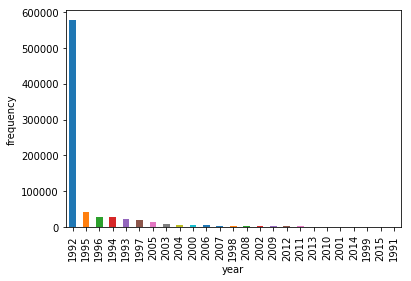

In [51]:
azdias["year"].value_counts().plot.bar()
plt.xlabel('year')
# naming the y axis
plt.ylabel('frequency')

So, that is an interesting result. 1992 dominates the distribution. Perhaps that is when this company started and so they had a massive mail campaign. 

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
1,910220,-1,9.0,0.0,0.0,0.0,0.0,0.0,21.0,11.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,1992
2,910225,-1,9.0,17.0,0.0,0.0,0.0,0.0,17.0,10.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,1992
3,910226,2,1.0,13.0,0.0,0.0,0.0,0.0,13.0,1.0,...,7.0,10.0,11.0,3.0,9.0,7.0,3,2,4,1997
4,910241,-1,1.0,20.0,0.0,0.0,0.0,0.0,14.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,1992
5,910244,3,1.0,10.0,0.0,0.0,0.0,0.0,10.0,5.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,1992


The next course of action is to split the two data frames into categorical and numerical, then scale the data, then finally to perform principle component analysis to reduce the size of the matrix by getting only the columns that contain the vast majority of useful information such that having more columns won't increase the accuracy of a supervised learning model. 

In [74]:
categories_df = azdias.select_dtypes(include=['object'])

In [35]:
customer_categories_df = customers.select_dtypes(include=['object'])

In [40]:
numerical_df = azdias.select_dtypes(exclude=['object'])

In [78]:
numerical_df.shape

(891221, 361)

In [36]:
customers_numerical_df = customers.select_dtypes(exclude=['object'])

In [30]:
customers_numerical_df.shape

(141224, 361)

In [23]:
pickle_out = open("cat_df.pickle","wb")
pickle.dump(categories_df, pickle_out)
pickle_out.close()

In [39]:
pickle_out = open("num_df.pickle","wb")
pickle.dump(numerical_df, pickle_out)
pickle_out.close()

In [4]:
pickle_in = open("cat_df.pickle","rb")
cat_df = pickle.load(pickle_in)

In [2]:
pickle_in = open("num_df.pickle","rb")
num_df = pickle.load(pickle_in)

In [3]:
num_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
1,910220,-1,9.0,0.0,0.0,0.0,0.0,0.0,21.0,11.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,1992
2,910225,-1,9.0,17.0,0.0,0.0,0.0,0.0,17.0,10.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,1992
3,910226,2,1.0,13.0,0.0,0.0,0.0,0.0,13.0,1.0,...,7.0,10.0,11.0,3.0,9.0,7.0,3,2,4,1997
4,910241,-1,1.0,20.0,0.0,0.0,0.0,0.0,14.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,1992
5,910244,3,1.0,10.0,0.0,0.0,0.0,0.0,10.0,5.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,1992


In [31]:
from sklearn.preprocessing import StandardScaler

In [40]:
x = numerical_df.values
x = StandardScaler().fit_transform(x) # normalizing the features

In [37]:
x2 = customers_numerical_df.values
x2 = StandardScaler().fit_transform(x2) # normalizing the features

In [41]:
num_cols = customers_numerical_df.columns

In [35]:
azdias_normalized = pd.DataFrame(x, columns= num_cols)

In [36]:
azdias_normalized.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,1.059975,-0.567115,1.260442,-1.427294,-0.332376,-0.193999,-0.087489,-0.038507,1.585109,0.171943,...,0.701913,1.069722,1.464892,-0.550387,0.565683,-0.026290,1.150844,0.957424,-1.681143,-0.432890
1,1.059995,-0.567115,1.260442,0.800605,-0.332376,-0.193999,-0.087489,-0.038507,0.696966,0.107952,...,1.052294,0.453700,0.021174,-0.550387,0.565683,-1.054882,1.150844,0.957424,0.169145,-0.432890
2,1.059999,1.867853,-0.938084,0.276393,-0.332376,-0.193999,-0.087489,-0.038507,-0.191176,-0.467965,...,0.351532,0.761711,1.825821,-0.550387,0.565683,1.516598,-0.270006,0.957424,1.094289,0.826064
3,1.060057,-0.567115,-0.938084,1.193763,-0.332376,-0.193999,-0.087489,-0.038507,0.030860,-0.339983,...,-1.049993,-0.778344,-0.700684,-1.083288,0.565683,-0.540586,0.440419,-1.044469,0.169145,-0.432890
4,1.060069,2.679510,-0.938084,-0.116765,-0.332376,-0.193999,-0.087489,-0.038507,-0.857282,-0.212002,...,1.402676,-0.162322,-0.700684,1.048317,0.565683,1.516598,0.440419,0.957424,-1.681143,-0.432890


In [42]:
customers_normalized = pd.DataFrame(x2, columns= num_cols)

In [43]:
customers_normalized.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,-1.560762,0.923349,-0.378148,-0.216330,-0.296669,-0.190588,-0.094156,-0.040739,-0.079045,-0.276900,...,0.216127,-0.541966,-0.521771,0.915498,0.303285,1.565140,0.451563,-0.702811,0.659862,-0.401428
1,0.865027,-1.328625,-0.378148,-0.853990,-0.296669,-0.190588,-0.094156,-0.040739,-2.539588,-0.276900,...,1.931159,2.936903,3.532861,0.915498,0.303285,-0.823935,0.451563,1.422857,0.659862,-0.401428
2,0.865045,0.172691,-0.378148,-0.535160,-0.296669,-0.190588,-0.094156,-0.040739,-0.571153,-0.346688,...,0.559133,-0.194079,-0.521771,-0.145798,0.303285,1.565140,-1.083197,-0.702811,0.659862,-0.401428
3,0.865063,-1.328625,-0.378148,1.377821,-0.296669,-0.190588,-0.094156,-0.040739,0.905173,0.141830,...,-0.469886,0.153808,0.379258,-1.207095,0.303285,-0.346120,-1.083197,-0.702811,-0.651136,-0.401428
4,0.865316,0.172691,-0.378148,-0.056915,-0.296669,-0.190588,-0.094156,-0.040739,-0.079045,-0.276900,...,-1.155899,-0.889853,-0.972286,0.915498,0.303285,-1.301751,-0.315817,-0.702811,-0.651136,-0.401428


In [37]:
pickle_out = open("azdias_normalized.pickle","wb")
pickle.dump(azdias_normalized, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("azdias_normalized.pickle","rb")
cat_df = pickle.load(pickle_in)

In [46]:
from sklearn.decomposition import PCA
pca_azdias = PCA(n_components = 115)
principalComponents_azdias = pca_azdias.fit_transform(azdias_normalized)

In [49]:
#principalComponents_azdias

In [50]:
feat_cols = ['P.C. '+str(i) for i in range(115)]

In [51]:
principal_azdias_Df = pd.DataFrame(data = principalComponents_azdias, columns = feat_cols)

In [52]:
principal_azdias_Df.head()

,P.C. 0,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6,P.C. 7,P.C. 8,P.C. 9,...,P.C. 105,P.C. 106,P.C. 107,P.C. 108,P.C. 109,P.C. 110,P.C. 111,P.C. 112,P.C. 113,P.C. 114
0,4.357949,-2.686793,2.751763,-4.330130,-5.847433,0.710224,-2.161084,-2.197095,1.571472,-0.499536,...,-0.451135,0.021346,-0.319694,-0.027375,0.322274,0.723072,0.326920,0.454614,0.255465,0.055651
1,0.404796,-0.505826,-1.478151,-3.620781,-3.826629,3.464453,-3.797769,2.832824,-1.011744,0.184299,...,0.723000,0.883712,-0.404162,0.268555,0.632250,-1.025649,0.399240,0.194861,-0.523152,0.647445
2,-2.545962,2.341619,-6.363824,-1.231388,-2.554267,-0.841669,-1.080907,-1.999031,-2.949173,-0.792421,...,-1.338479,-1.033119,1.423539,-1.112979,-0.150760,-0.077029,-0.172301,1.858425,0.035088,-0.034783
3,-6.646744,0.282048,8.231780,-2.444807,6.532282,-3.005551,3.460066,-0.437457,-4.403760,5.220362,...,0.156021,-1.511885,-0.749572,-1.140425,-0.544928,-1.918031,2.238957,1.184292,0.146953,0.014598
4,-1.996931,0.515861,-3.453864,-2.466997,-2.273643,0.844510,0.244811,-1.381603,-1.284345,2.668562,...,1.126829,0.264984,-0.724236,1.551176,0.298253,0.355539,0.218453,1.434819,-0.801083,-0.578561


In [53]:
principal_azdias_Df.shape

(792242, 115)

Next order of business is to make a data frame that shows the variance of the PCA. 

In [54]:
explained_variance = pca_azdias.explained_variance_ratio_

In [55]:
cumulative_variance = np.cumsum(np.round(explained_variance, decimals = 3))

In [56]:
pca_df = pd.DataFrame(feat_cols, columns = ['PC'])

In [57]:
explained_variance_df = pd.DataFrame(explained_variance, columns = ['Explained Variance'])

In [58]:
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns = ['Cumulative Variance'])

In [59]:
df_explained_variance = pd.concat([pca_df, explained_variance_df, cumulative_variance_df], axis = 1)

In [60]:
df_explained_variance.head(15)

,PC,Explained Variance,Cumulative Variance
0,P.C. 0,0.081054,0.081
1,P.C. 1,0.072575,0.154
2,P.C. 2,0.050273,0.204
3,P.C. 3,0.044235,0.248
4,P.C. 4,0.037588,0.286
5,P.C. 5,0.022005,0.308
6,P.C. 6,0.019698,0.328
7,P.C. 7,0.016449,0.344
8,P.C. 8,0.015081,0.359
9,P.C. 9,0.013809,0.373


In [61]:
df_explained_variance.tail(10)

,PC,Explained Variance,Cumulative Variance
105,P.C. 105,0.002046,0.781
106,P.C. 106,0.002039,0.783
107,P.C. 107,0.002033,0.785
108,P.C. 108,0.001997,0.787
109,P.C. 109,0.001986,0.789
110,P.C. 110,0.001976,0.791
111,P.C. 111,0.001967,0.793
112,P.C. 112,0.001943,0.795
113,P.C. 113,0.001915,0.797
114,P.C. 114,0.001893,0.799


Next, create visualization of how the variance increases along with the number of PC's! 

In [63]:
pc_num = []
for i in range(115):
    pc_num.append(i)

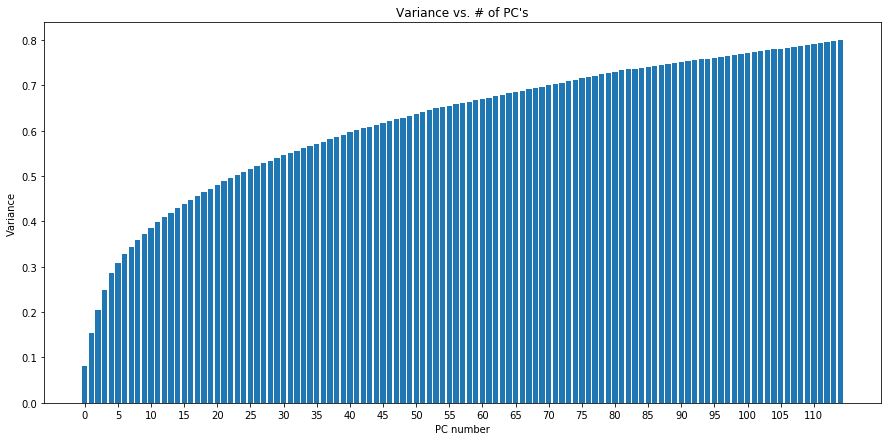

In [64]:
plt.figure(figsize=(15,7))
plt.bar(pc_num, cumulative_variance)
plt.xticks(np.arange(0, 115, 5))
plt.xlabel('PC number')
# naming the y axis
plt.ylabel('Variance')
plt.title("Variance vs. # of PC's")
plt.show()

So, having 115 PC's retains 79.9% of the variance. It takes a good chunk of time to compute that so increasing the amount of PC's would only increase the amount of computation time. There is a time vs. accuracy balance that has to be acheived while working with massive datasets like this. Hopefully 79.9% is enough to have an accurate enough Supervised Learning model. 

It would be desirable to know what are the most and least dominating numerical columns of the original data frame for each principle component. This can be ascertained using .components_ method:

In [65]:
pca_relevance = pca_azdias.components_
pca_relevance.shape

(115, 361)

In [66]:
type(pca_relevance)

numpy.ndarray

So, now the pca_relevance numpy array provides the information as to what the weight is of each numerical column for the respective principal component. Convert the numpy array to a data frame so its easier to work with!

In [69]:
pc_relevance = pd.DataFrame(pca_relevance, columns = num_cols)

In [70]:
pc_relevance.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,-0.014827,-0.017281,0.071917,-0.057317,-0.045996,-0.032307,-0.015637,-0.006954,-0.002393,0.076733,...,0.114763,0.110011,0.091295,0.062731,-0.014463,-0.043429,0.073416,0.004541,-0.010580,-0.037844
1,0.009139,0.015982,-0.012231,-0.007499,-0.000256,0.001053,0.000267,-0.000101,-0.025735,-0.001133,...,-0.007591,-0.016067,-0.021164,0.001495,0.012081,0.013107,-0.031459,0.000201,0.029257,0.009350
2,-0.008063,-0.087883,0.004207,0.090138,0.074237,0.048806,0.024364,0.011534,0.131443,0.029670,...,-0.107052,-0.065240,-0.014172,-0.087678,-0.060503,-0.024666,0.043238,0.009276,-0.131862,0.009042
3,-0.087270,0.004166,-0.005592,0.004653,0.001577,-0.000905,0.000341,0.001209,0.000784,-0.008666,...,-0.006638,-0.011584,-0.016732,-0.004090,0.007012,0.079575,0.016246,-0.004681,0.005417,0.019774
4,-0.039994,0.122113,-0.100796,0.003402,-0.014913,-0.010649,-0.006281,-0.003188,-0.102066,0.039273,...,-0.077782,-0.115782,-0.130411,0.036893,0.036380,-0.063188,-0.051701,-0.005858,0.129261,-0.025820


So, this looks really good because now the data frame 'pc_relevance' informs what the columns weights are for each principle component. The principle component is the row in this data frame. 

In [102]:
pickle_out = open("pc_relevance","wb")
pickle.dump(pc_relevance, pickle_out)
pickle_out.close()

In [3]:
pickle_in = open("pc_relevance","rb")
pc_relevance = pickle.load(pickle_in)

In [3]:
pc_relevance.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
0,-0.014827,-0.017281,0.071917,-0.057317,-0.045996,-0.032307,-0.015637,-0.006954,-0.002393,0.076733,...,0.114763,0.110011,0.091295,0.062731,-0.014463,-0.043429,0.073416,0.004541,-0.010580,-0.037844
1,0.009139,0.015982,-0.012231,-0.007499,-0.000256,0.001053,0.000267,-0.000101,-0.025735,-0.001133,...,-0.007591,-0.016067,-0.021164,0.001495,0.012081,0.013107,-0.031459,0.000201,0.029257,0.009350
2,-0.008063,-0.087883,0.004207,0.090138,0.074237,0.048806,0.024364,0.011534,0.131443,0.029670,...,-0.107052,-0.065240,-0.014172,-0.087678,-0.060503,-0.024666,0.043238,0.009276,-0.131862,0.009042
3,-0.087270,0.004166,-0.005592,0.004653,0.001577,-0.000905,0.000341,0.001209,0.000784,-0.008666,...,-0.006638,-0.011584,-0.016732,-0.004090,0.007012,0.079575,0.016246,-0.004681,0.005417,0.019774
4,-0.039994,0.122113,-0.100796,0.003402,-0.014913,-0.010649,-0.006281,-0.003188,-0.102066,0.039273,...,-0.077782,-0.115782,-0.130411,0.036893,0.036380,-0.063188,-0.051701,-0.005858,0.129261,-0.025820


In [83]:
comp_0 = pc_relevance.iloc[0]

In [114]:
comp_0

LNR                          -0.014827
AGER_TYP                     -0.017281
AKT_DAT_KL                    0.071917
ALTER_HH                     -0.057317
ALTER_KIND1                  -0.045996
ALTER_KIND2                  -0.032307
ALTER_KIND3                  -0.015637
ALTER_KIND4                  -0.006954
ALTERSKATEGORIE_FEIN         -0.002393
ANZ_HAUSHALTE_AKTIV           0.076733
ANZ_HH_TITEL                  0.020756
ANZ_KINDER                   -0.044509
ANZ_PERSONEN                 -0.089931
ANZ_STATISTISCHE_HAUSHALTE    0.077094
ANZ_TITEL                    -0.001346
ARBEIT                        0.076202
BALLRAUM                     -0.061742
CJT_GESAMTTYP                -0.007313
CJT_KATALOGNUTZER             0.050975
CJT_TYP_1                     0.017445
CJT_TYP_2                     0.036892
CJT_TYP_3                    -0.034585
CJT_TYP_4                     0.001130
CJT_TYP_5                    -0.034039
CJT_TYP_6                    -0.015171
D19_BANKEN_ANZ_12        

In the next step a function will be created that gives the most and least relevant columns of a given principle component through a bar graph and explains what each means:

In [ ]:
def relevant_columns(pc):
    "This function takes the n'th principle component as an input and outputs information about the customers \
    including the top five most pertinent and least pertinent columns and their descriptions if one is available"
    descriptions = []
    descriptions_parsed = []

    
    pc_info = list(zip(pc_relevance.iloc[pc], num_cols))
    pc_info.sort()
    most_important = pc_info[-5:]
    most_important.sort(reverse = True)
    least_important = pc_info[0:5]
    least_important.sort(reverse = True)
    full_list = most_important + least_important
    unzipped_full = list(zip(*full_list))
    full_vals = unzipped_full[0]
    full_col_names = unzipped_full[1]
    plt.figure(figsize=(25,7))
    #plt.bar(most_important_col_names, most_important_vals)
    s = pd.Series(full_vals, index = full_col_names)
    s.plot(kind='bar',rot=0, title = "PC Variance of a Column vs. Column Name")
    plt.xlabel('Column Name')
    plt.ylabel('Variance')
    
    for name in full_col_names:
        description = feature_values[feature_values['Attribute'] == name]['Description'][0:1]
        descriptions.append(str(description))
    for desc in descriptions:
        descriptions2 = desc.split("\nName")[0][4:]
        descriptions_parsed.append(descriptions2)
    component_info = {"Feature":full_col_names, "Description":descriptions_parsed, "Variance": full_vals}
    component_info = pd.DataFrame(component_info)
    component_info
    
    component_info['Description'].replace('es([], Name: Description, dtype: object)', 'Unknown description', inplace=True)

    return component_info

,Feature,Description,Variance
0,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,0.121068
1,KBA13_ANTG3,Unknown description,0.120563
2,KBA13_ANTG4,Unknown description,0.118325
3,PLZ8_ANTG4,number of >10 family houses in the PLZ8,0.117854
4,KBA13_BAUMAX,Unknown description,0.117673
5,MOBI_RASTER,Unknown description,-0.118471
6,LP_STATUS_FEIN,social status fine,-0.120273
7,KBA13_ANTG1,Unknown description,-0.120789
8,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,-0.121618
9,MOBI_REGIO,moving patterns,-0.130466


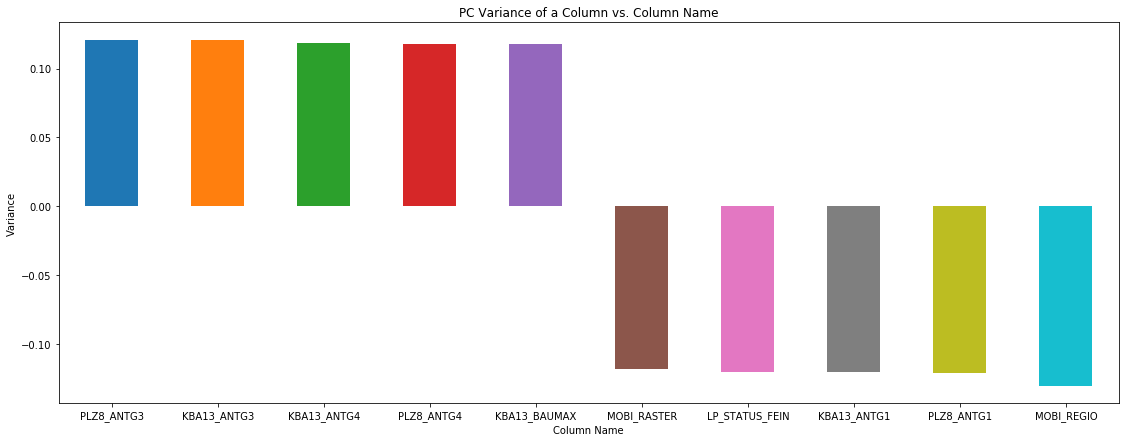

In [255]:
relevant_columns(0)

,Feature,Description,Variance
0,KBA05_SEG6,share of upper class cars (BMW 7er etc.) i...,0.174207
1,KBA05_KRSOBER,share of upper class cars (referred to the ...,0.160317
2,KBA05_KRSVAN,share of vans (referred to the county average),0.157418
3,KBA05_ANHANG,share of trailers in the microcell,0.157385
4,KBA05_KRSZUL,share of newbuilt cars (referred to the cou...,0.157025
5,FINANZ_SPARER,financial typology: money saver,-0.042192
6,HH_EINKOMMEN_SCORE,estimated household net income,-0.043057
7,KBA05_ANTG3,number of 6-10 family houses in the cell,-0.044352
8,KBA13_ANTG3,Unknown description,-0.044900
9,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.045000


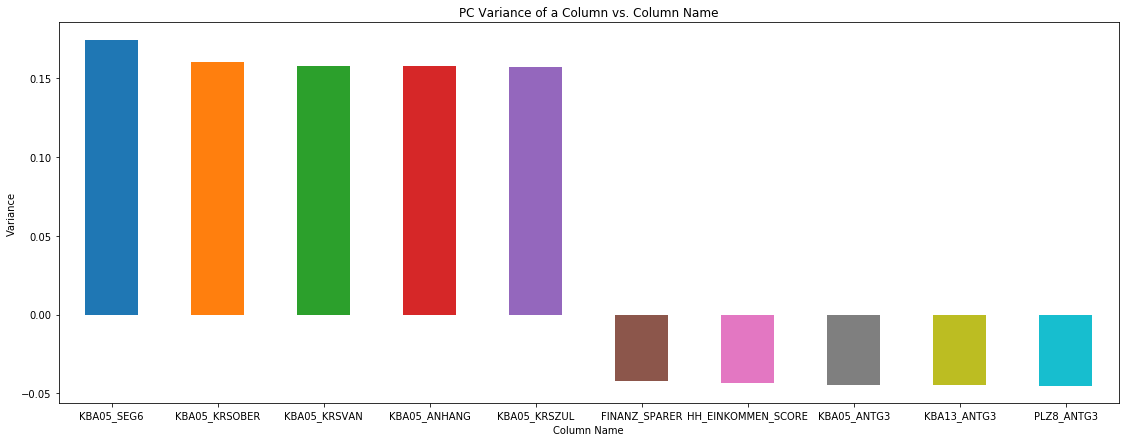

In [257]:
relevant_columns(1)

,Feature,Description,Variance
0,CJT_TYP_2,Unknown description,0.159570
1,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth ...,0.154884
2,CJT_TYP_1,Unknown description,0.153115
3,FINANZ_SPARER,financial typology: money saver,0.149798
4,ONLINE_AFFINITAET,online affinity,0.148473
5,FINANZ_VORSORGER,financial typology: be prepared,-0.140772
6,CJT_TYP_6,Unknown description,-0.142135
7,CJT_TYP_4,Unknown description,-0.143346
8,CJT_TYP_3,Unknown description,-0.146161
9,CJT_TYP_5,Unknown description,-0.146648


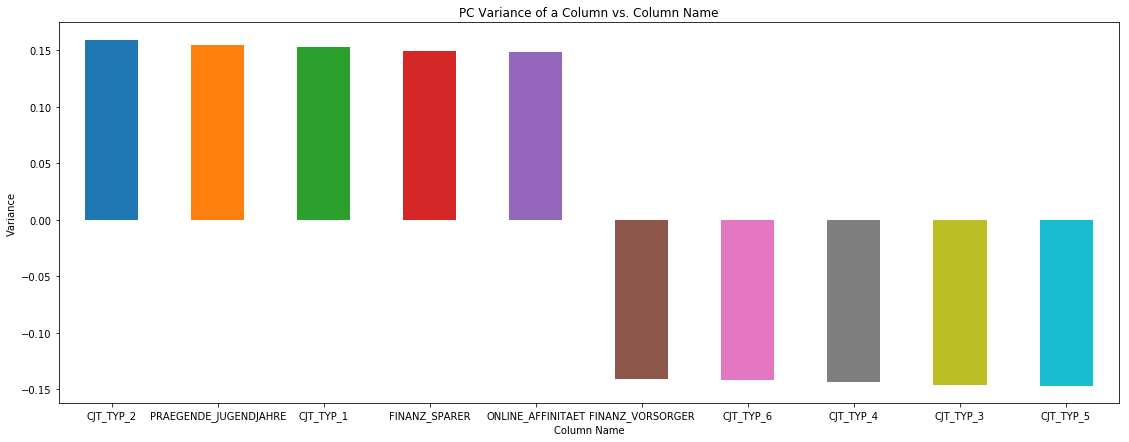

In [258]:
relevant_columns(2)

,Feature,Description,Variance
0,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,0.162700
1,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford F...,0.145490
2,KBA13_KMH_140_210,share of cars with max speed between 140 a...,0.145193
3,KBA13_KMH_180,share of cars with max speed between 110 k...,0.136588
4,KBA13_HALTER_25,share of car owners between 21 and 25 with...,0.133327
5,KBA13_SITZE_4,number of cars with less than 5 seats in t...,-0.155184
6,KBA13_BMW,share of BMW within the PLZ8,-0.164600
7,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper...,-0.168831
8,KBA13_MERCEDES,share of MERCEDES within the PLZ8,-0.171247
9,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,-0.198894


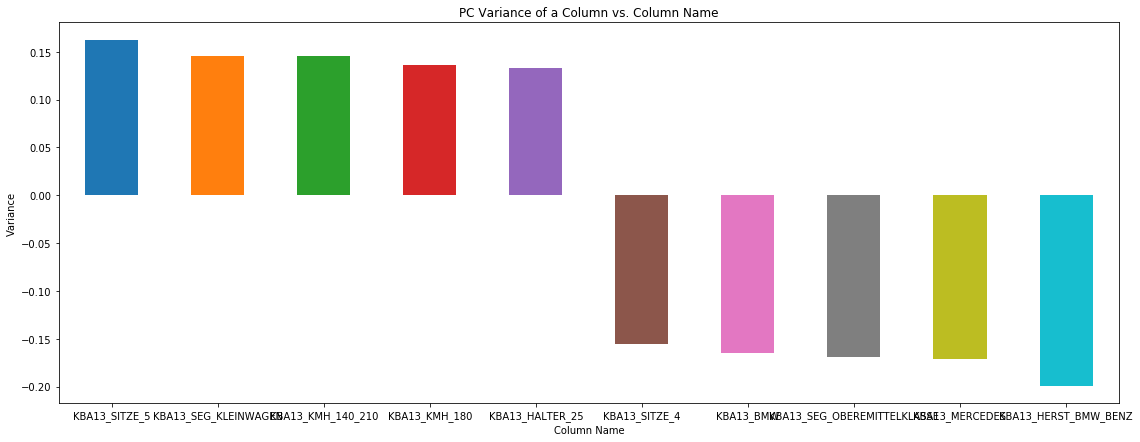

In [259]:
relevant_columns(3)

In [ ]:
kmeans_kwargs = {"init": "random", "n_init": 10, "random_state": 42}
 
# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pc_150)
    sse.append(kmeans.inertia_)

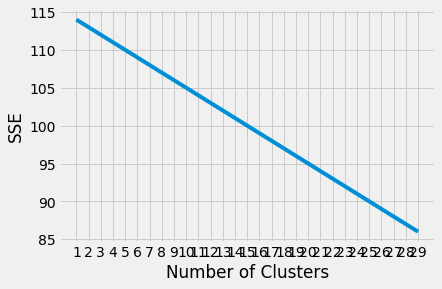

In [29]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 30,1), sse)
plt.xticks(range(1, 30,1))
plt.figure(figsize=(17,7))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

This does not look good. The curve above should be non linear with the magnitude of the slope decreasing as the number of clusters gets larger. Try doing this with more principle components such as 150 and see if that looks better.

In [44]:
from sklearn.decomposition import PCA

In [84]:
pc_150_azdias = pca_Kmeans.fit_transform(azdias_normalized)
# It may be noted that there is no code to explain what "pca_Kmeans" is. This was a data frame that was saved in the 
# workspace memory using 'pickle' but had to be deleted for memory purposes. 
pc_150_azdias = pd.DataFrame(pc_150_azdias)

In [ ]:
pca_azdias = PCA(n_components = 115)
principalComponents_azdias = pca_azdias.fit_transform(azdias_normalized)

In [45]:
pca_customers = PCA(n_components = 150)
PCA_customers = pca_customers.fit_transform(customers_normalized)

In [46]:
pca_customers = pd.DataFrame(PCA_customers)

In [47]:
pca_customers.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-1.876139,4.427632,6.165661,-1.022840,1.452315,-2.488718,-1.826164,-0.579790,-0.416523,0.744428,...,0.478649,-0.087753,-0.964038,-0.723004,0.043030,1.049721,1.498884,-0.635167,-0.777891,1.090977
1,7.748175,-0.664548,2.685822,0.809926,0.205367,-1.520147,-4.056791,2.753590,0.414934,-1.952528,...,-0.078087,0.535283,-0.994982,0.349424,-0.063326,-0.179801,0.566036,-0.779925,-0.511034,-1.605191
2,-1.069684,-0.547114,5.344158,-1.247243,2.014136,1.103502,2.005031,-3.521527,-3.672998,0.283900,...,0.031529,0.092744,0.456650,-0.269991,1.295888,-0.561716,-1.213935,-0.134180,0.537022,1.162982
3,-2.207030,-6.120290,-8.846329,0.409344,-1.625838,-2.691615,-2.420923,1.354137,0.005585,3.009942,...,-0.113352,2.946477,0.703265,-0.036012,0.822117,0.941384,1.770928,-0.976764,-0.494068,-0.766234
4,3.028027,7.269874,0.242391,-0.988950,-0.738214,-1.244766,-0.460671,-0.815954,-1.800062,-2.641887,...,-0.146997,-1.627502,0.381721,-0.881461,0.106664,-0.291850,0.049775,-0.750094,-0.144729,0.902173


In [48]:
feat_cols_150 = ['P.C. '+str(i) for i in range(150)]

In [50]:
pc_150_Df = pd.DataFrame(data = pc_150_azdias, columns = feat_cols_150)

In [43]:
pc_150_Df.head()

,P.C. 0,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6,P.C. 7,P.C. 8,P.C. 9,...,P.C. 140,P.C. 141,P.C. 142,P.C. 143,P.C. 144,P.C. 145,P.C. 146,P.C. 147,P.C. 148,P.C. 149
0,4.357949,-2.686793,2.751760,-4.330127,-5.847427,0.710251,-2.161069,-2.197142,1.571623,-0.499186,...,0.044844,0.582675,-0.340321,0.978288,0.691401,0.496448,1.345892,0.128840,0.359841,0.416085
1,0.404796,-0.505826,-1.478153,-3.620785,-3.826625,3.464463,-3.797842,2.832497,-1.011744,0.184187,...,-0.695435,-0.675957,-0.265768,-0.217269,-0.558857,-1.345206,-0.717185,-0.854064,-0.607732,-0.818315
2,-2.545962,2.341618,-6.363823,-1.231387,-2.554269,-0.841665,-1.080875,-1.999057,-2.949184,-0.792412,...,0.145758,0.661842,0.045168,-0.633604,-0.823823,0.818750,0.302253,-0.229518,-0.127217,-0.655041
3,-6.646744,0.282048,8.231780,-2.444811,6.532290,-3.005493,3.460174,-0.437487,-4.403918,5.220393,...,-1.370355,0.262234,-0.514788,0.575119,1.597785,0.642153,-0.332355,0.732290,-0.195502,-1.546355
4,-1.996931,0.515861,-3.453864,-2.466994,-2.273641,0.844504,0.244718,-1.381395,-1.284330,2.668539,...,-0.723250,0.452065,-0.345906,0.633772,0.501902,-0.310561,-0.076472,-0.920712,-1.009639,-0.708464


In [51]:
pca_customers.columns = feat_cols_150

In [52]:
pca_customers.head()

,P.C. 0,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6,P.C. 7,P.C. 8,P.C. 9,...,P.C. 140,P.C. 141,P.C. 142,P.C. 143,P.C. 144,P.C. 145,P.C. 146,P.C. 147,P.C. 148,P.C. 149
0,-1.876139,4.427632,6.165661,-1.022840,1.452315,-2.488718,-1.826164,-0.579790,-0.416523,0.744428,...,0.478649,-0.087753,-0.964038,-0.723004,0.043030,1.049721,1.498884,-0.635167,-0.777891,1.090977
1,7.748175,-0.664548,2.685822,0.809926,0.205367,-1.520147,-4.056791,2.753590,0.414934,-1.952528,...,-0.078087,0.535283,-0.994982,0.349424,-0.063326,-0.179801,0.566036,-0.779925,-0.511034,-1.605191
2,-1.069684,-0.547114,5.344158,-1.247243,2.014136,1.103502,2.005031,-3.521527,-3.672998,0.283900,...,0.031529,0.092744,0.456650,-0.269991,1.295888,-0.561716,-1.213935,-0.134180,0.537022,1.162982
3,-2.207030,-6.120290,-8.846329,0.409344,-1.625838,-2.691615,-2.420923,1.354137,0.005585,3.009942,...,-0.113352,2.946477,0.703265,-0.036012,0.822117,0.941384,1.770928,-0.976764,-0.494068,-0.766234
4,3.028027,7.269874,0.242391,-0.988950,-0.738214,-1.244766,-0.460671,-0.815954,-1.800062,-2.641887,...,-0.146997,-1.627502,0.381721,-0.881461,0.106664,-0.291850,0.049775,-0.750094,-0.144729,0.902173


In [44]:
pickle_out = open("pc_150","wb")
pickle.dump(pc_150_Df, pickle_out)
pickle_out.close()

In [53]:
pickle_in = open("pc_150","rb")
pc_150 = pickle.load(pickle_in)

In [5]:
def Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("K-means clustering initiated")
    print("for range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for cluster", n)
        
        kmeans = KMeans(n)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("The score for this cluster is: ", scores[-1])        
    return scores, range(K_start, K_end+1, step)

In [4]:
Kmeans_scores(pc_150,2, 15, 1)

K-means clustering initiated
for range min:2, max:15, step:1

Training for cluster 2
The score for this cluster is:  211100596.741

Training for cluster 4
The score for this cluster is:  202741037.843

Training for cluster 5
The score for this cluster is:  198345357.291

Training for cluster 6
The score for this cluster is:  194767205.093

Training for cluster 7
The score for this cluster is:  191827382.815

Training for cluster 8
The score for this cluster is:  189569981.133

Training for cluster 9
The score for this cluster is:  187555198.021

Training for cluster 10
The score for this cluster is:  185878043.173

Training for cluster 11
The score for this cluster is:  184376800.549

Training for cluster 12
The score for this cluster is:  183030188.967

Training for cluster 13
The score for this cluster is:  181865120.353

Training for cluster 14
The score for this cluster is:  180758921.371

Training for cluster 15
The score for this cluster is:  179864219.693


([231103428.14647099,
  211100596.74051625,
  202741037.84301257,
  198345357.29066706,
  194767205.09312871,
  191827382.81548285,
  189569981.13336748,
  187555198.02096623,
  185878043.17290056,
  184376800.54944414,
  183030188.96732891,
  181865120.35346353,
  180758921.3712903,
  179864219.6932742],
 range(2, 16))

In [10]:
scores = ([231103428.14647099,
  211100596.74051625,
  202741037.84301257,
  198345357.29066706,
  194767205.09312871,
  191827382.81548285,
  189569981.13336748,
  187555198.02096623,
  185878043.17290056,
  184376800.54944414,
  183030188.96732891,
  181865120.35346353,
  180758921.3712903,
  179864219.6932742])

In [28]:
len(scores)

14

In [ ]:
from matplotlib import pyplot as plt

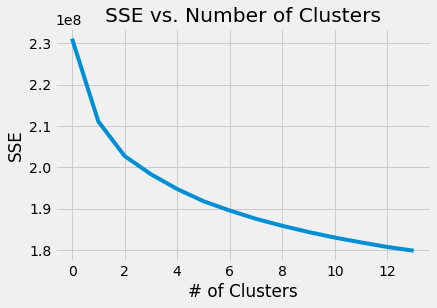

In [30]:
plt.plot(scores)
plt.xlabel("# of Clusters")
plt.ylabel("SSE")
plt.title("SSE vs. Number of Clusters")
plt.show()

In [62]:
kmeans = KMeans(8, random_state=21)

kmeans.fit(pc_150)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=21, tol=0.0001, verbose=0)

In [63]:
azdias_clusters = kmeans.predict(pc_150)

In [65]:
azdias_clusters = pd.Series(azdias_clusters)

In [66]:
azdias_clusters.value_counts().sort_index()

0     72719
1     92953
2    102689
3    135321
4    102789
5    136271
6     14490
7    135010
dtype: int64

In [67]:
customers_clusters = kmeans.predict(pca_customers)

In [68]:
customers_clusters = pd.Series(customers_clusters)

In [69]:
customers_clusters.value_counts().sort_index()

0    25776
1    10114
2    19181
3    24400
4    14189
5    20985
6       66
7    26513
dtype: int64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

Selecting subsets of a DataFrame https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html

PCA article:
https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c